In [92]:
from __future__ import print_function, division

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path
import copy
import torchsummary
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm
#from barbar import Bar
import pickle
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cudnn.benchmark = True
plt.ion()   # interactive mode

selected_gpu = 1 # here you select the GPU used (0, 1 or 2)
device = torch.device("cuda:" + str(selected_gpu) if
torch.cuda.is_available() else "cpu")
print(f'the device is {device}')


the device is cpu


In [2]:
#if running locally
notebook_path = Path().cwd()
#if running in colab
# from google.colab import drive
# drive._mount('/content/drive')
#notebook_path = Path('/content/drive/MyDrive/MAIA/3rd_semester/CAD/Projecte/Deep_Learning/notebooks')

project_path = notebook_path.parent
repo_path = project_path.parent
os.chdir(notebook_path)
print(f'The current directory is {Path().cwd()}')

The current directory is /home/ricardino/Documents/MAIA/tercer_semestre/CAD/Projecte/Deep_Learning/notebooks


# MAIN

## Accuracy and loss

Text(0.5, 1.0, 'Vgg19_bn accuracy')

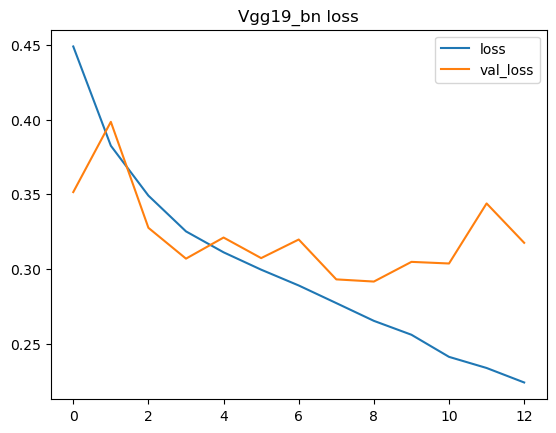

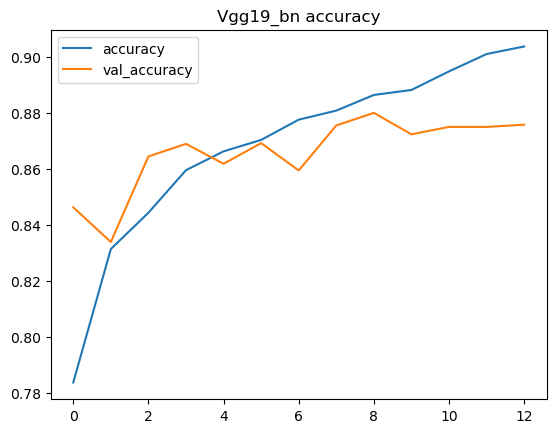

In [3]:
# Let's check the loss and accuracy of the model
model_name = 'vgg19_bn'
with_epoch = False
epoch_num = 9

#statistics path
statistics_pah = project_path / 'data'/'results' / f'{model_name}_stats_epoch{epoch_num}.csv' if with_epoch else project_path / 'data'/'results' / f'{model_name}_stats.csv'
#read csv file
df = pd.read_csv(statistics_pah)
#plot loss and validation loss
df[['loss', 'val_loss']].plot()
plt.title(f'{model_name.capitalize()} loss')
#plot accuracy and validation accuracy
df[['accuracy', 'val_accuracy']].plot()
plt.title(f'{model_name.capitalize()} accuracy')

## Confusion matrix

### Setting up data
First define the parameters and the dataloder

In [4]:
#@markdown ## Hyperparameters
batch_size =  4 #@param
num_workers =  2 #@param

#challenge type (binary or 3-classes)
num_classes = 2 #@param

#image size 
height = 450
width = 600

#cropping
center_crop = 448

In [5]:
data_transforms = {
    'val': transforms.Compose([ #for validation we only resize and crop
        transforms.Resize((height, width)),
        transforms.CenterCrop(center_crop),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ #for test we only resize and crop
        transforms.Resize((height, width)),
        transforms.CenterCrop(center_crop),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
#directory of the data
data_dir = repo_path /'Machine_Learning'/'images' / 'binary'
folders_list = ['val', 'test']

#get the data info
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in folders_list}
#get dataloader
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers) #SHUFFLWE IS OFF
              for x in folders_list}
#size of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in folders_list}
#get classes names
class_names = image_datasets['test'].classes

#print info
for key in dataset_sizes.keys():
    print(f'Number of {key} images: {dataset_sizes[key]}')

Number of val images: 3796
Number of test images: 6340


Check that the data is fine

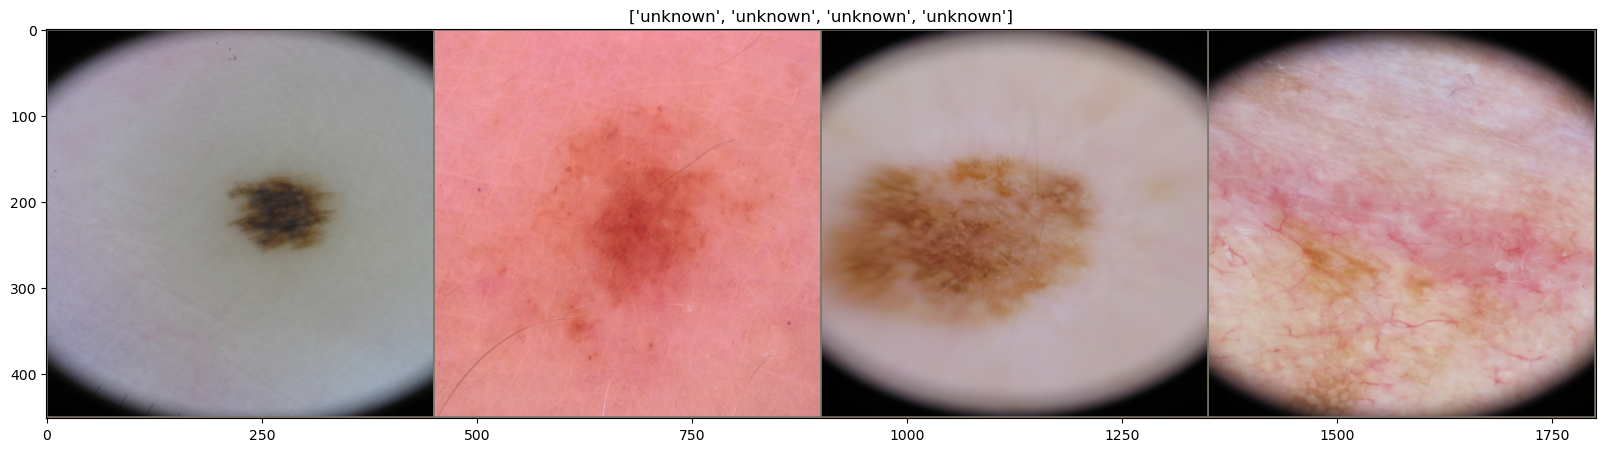

In [6]:
def imshow(input:torch.Tensor, title=None):
    """shows a preprocessed tensor in its original form

    Args:
        input (torch.Tensor): input tensor
        title (_type_, optional): _description_. Defaults to None.
    """
    #get numpy, and put color at the end
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #scale back
    input = std * input + mean
    input = np.clip(input, 0, 1)
    #plot
    plt.figure(figsize=(20,10))
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid (fused_image) from batch
out = torchvision.utils.make_grid(inputs)
#show the fused_image
imshow(out, title=[class_names[x] for x in classes])

### Load model

In [32]:
# Let's check the confusion matrix
model_name = 'efficientnet_b7'
#model weights
model_weights_path = project_path / 'data'/'models'/'binary'/f'{model_name}_epoch15.pt'
#get the model
model = getattr(torchvision.models, model_name)(weights='DEFAULT')

#change last layer to have two outputs
#Densenet classifier
in_fts_fc = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_fts_fc, num_classes)

#load model
model.load_state_dict(torch.load(model_weights_path, map_location=device))
#send to device
model = model.to(device)

### Predict

In [80]:
def get_outputs(model:nn.Module, num_classes:int, set_dataloader:DataLoader, device:torch.device):
    """give model and dataloader, return the outputs

    Args:
        model (nn.Module): pretrained model
        num_classes (int): number of classes
        set_dataloader (DataLoader): dataloader of the set
        device (torch.device): device to perform the operation

    Returns:
        np.ndarray: array with the outputs (not predicted labels)
    """
    #pridict and append prediction inan effective way
    with torch.no_grad():
        #set model to evaluation mode
        model.eval()
        #create numpy array to store predictions
        y_pred = np.empty((0, num_classes))
        #go through all the data in dataloader
        for inputs, labels in tqdm(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            #run forward pass
            outputs = model(inputs)
            #concatenate predictions
            y_pred = np.concatenate((y_pred, outputs.cpu().numpy()), axis=0)
    return y_pred

### Confusion matrix

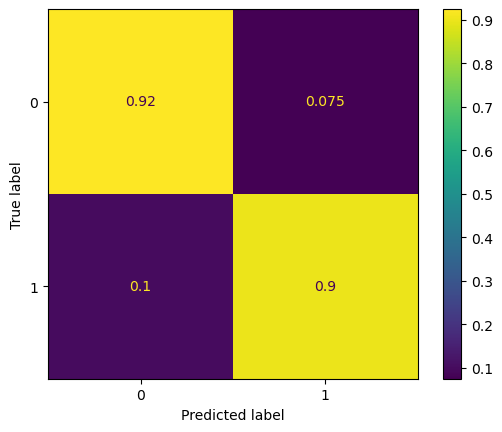

In [102]:
# Get the outputs from pieckle file
with open(project_path / 'data'/'results' /'outputs' /f'{model_name}_outputs.pkl', 'rb') as f:
    outputs = pickle.load(f)
#get prediction from outputs
pred = np.argmax(outputs, axis=1)
#get labels from dataloader
labels = np.array(image_datasets['val'].targets)

#plot confusion matrix as probability
ConfusionMatrixDisplay.from_predictions(labels, pred, normalize='true')